In [9]:
import os

import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
import torch

from loss_traces.config import STORAGE_DIR

# from loss_traces.config import MODEL_DIR
from loss_traces.data_processing.data_processing import (
    get_no_shuffle_train_loader,
    get_num_classes,
    prepare_transform,
    get_trainset,
    get_testset
)
from loss_traces.models.model import load_model
from loss_traces.results.final_model_metrics import get_final_model_metrics
from loss_traces.results.result_processing import (
    get_attackr_scores,
    get_lira_scores,
    get_rmia_scores,
    get_trace_reduction,
)
from loss_traces.results.utils import (
    make_precision_recall_at_k_df_single_threshold,
    make_precision_recall_at_k_df,
)
from loss_traces.attacks import AttackConfig, RMIAAttack
from sklearn.metrics import roc_curve





In [2]:
from privacy_onion.layer_utils import (save_layer_target_indices)

In [30]:
exp_id = 'wrn28-2_CIFAR10_l1'
layer = 1
exp_path = 'testpkl'
save_layer_target_indices(exp_id, layer, exp_path, top_k=0.05, random=False)

39556    39556
10165    10165
19620    19620
41478    41478
18647    18647
         ...  
2954      2954
34291    34291
3230      3230
46090    46090
16242    16242
Name: og_idx, Length: 22563, dtype: int64


In [6]:
os.chdir("../")
plt.style.use("plot_style.mplstyle")

In [29]:
MODEL_DIR = f"{STORAGE_DIR}/models"
def get_lt_iqr(exp_id):
    saves = torch.load(f"{MODEL_DIR}/{exp_id}/target", weights_only=False)

    df = pd.DataFrame(get_trace_reduction(exp_id, reduction="iqr"), columns=["lt_iqr"])
    df['og_idx'] = df.index
    df['target_trained_on'] = df.index.isin(saves['trained_on_indices'])
    
    return df 
def save_layer_target_indices(exp_id, layer, exp_path, top_k=0.05, random=False):
    os.makedirs(f"{STORAGE_DIR}/layer_target_indices", exist_ok=True)

    save_path = f"{STORAGE_DIR}/layer_target_indices/{exp_path}"
    os.makedirs(save_path, exist_ok=True)

    df = get_lt_iqr(exp_id)

    members = df[df['target_trained_on'] == True]
    top_score = members.sort_values(by='lt_iqr', ascending=False)

    idx = int(len(top_score) * top_k)
    if random is False:
        vulnerable = top_score[:idx]['og_idx']
        safe = top_score[idx:]['og_idx']
        print(safe)
    else:
        og_idx = top_score['og_idx'].values
        random_sample = np.random.choice(og_idx, size=idx, replace=False)
        vulnerable = top_score[top_score['og_idx'].isin(random_sample)]['og_idx']
        safe = top_score[~top_score['og_idx'].isin(random_sample)]['og_idx']


    # create safe fulset that is all prev_ safe fulset - vulnerable if layer > 0, if not then len(idx) - vulnerable

    if layer > 0:
        prev_safe = pd.read_pickle(f"{save_path}/layer_{layer - 1}_full_safe.pkl")
        full_safe = prev_safe[~prev_safe['og_idx'].isin(vulnerable)]
    else:
        full_safe = pd.DataFrame({'og_idx': np.arange(len(df))})
        full_safe = full_safe[~full_safe['og_idx'].isin(vulnerable)]

    full_safe.to_pickle(
        f"{save_path}/layer_{layer}_full_safe.pkl")
    
    safe.to_pickle(f"{save_path}/layer_{layer}_safe.pkl")

In [3]:
os.makedirs("figures", exist_ok=True)
os.makedirs(f"{STORAGE_DIR}/layer_target_indices", exist_ok=True)

## WRN28-2 CIFAR10

In [11]:
exp_id = "wrn28-2_CINIC_l0"
MODEL_DIR = "trained_models"
config = {
    "dataset": "CINIC10",
    "arch": "wrn28-2",
    "batchsize": 264,
    "num_workers": 4,
    "augment": True,
    "device": "cuda",
}


def _initialize_model_and_data(config):
    attack_loaders = [
        get_no_shuffle_train_loader(
            config["dataset"],
            config["arch"],
            config["batchsize"],
            config["num_workers"],
        )
    ]

    if config["augment"]:
        attack_loaders.append(
            get_no_shuffle_train_loader(
                config["dataset"],
                config["arch"],
                config["batchsize"],
                config["num_workers"],
                mirror_all=True,
            )
        )

    model = load_model(config["arch"], get_num_classes(config["dataset"])).to(
        config["device"]
    )

    return model, attack_loaders


saves = torch.load(f"{MODEL_DIR}/models/{exp_id}/shadow_0", weights_only=False)

model, data_loader = _initialize_model_and_data(config)
model.load_state_dict(saves["model_state_dict"])


<All keys matched successfully>

In [12]:
transform = prepare_transform("CINIC10", arch= "wrn28-2", augment=True)
testset = get_testset("CINIC10", transform=transform)
test_loader = torch.utils.data.DataLoader(
    testset,
    batch_size=config["batchsize"],
    shuffle=True,
    num_workers=config["num_workers"],
    pin_memory=True,
)

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets, _indices in test_loader:
        inputs, targets = inputs.to(config["device"]), targets.to(config["device"])
        outputs = model(inputs).squeeze(-1).squeeze(-1)

        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct_idx = predicted.eq(targets.data).cpu()

        correct += correct_idx.sum().item()
accuracy = 100 * correct / total
print(f"Accuracy of the model on the test set: {accuracy:.2f}%")


Accuracy of the model on the test set: 80.68%


In [ ]:
# Accuracy of the model on the test set: 66.34%


In [23]:
exp_id = "wrn28-2_CIFAR10"

df = get_lira_scores(exp_id, n_shadows=32)
# df["attackr_score"] = get_attackr_scores(exp_id)
# df["rmia_score"] = get_rmia_scores(exp_id, "target", return_full_df=False)


df["lt_iqr"] = get_trace_reduction(exp_id, reduction="iqr")
members = df[df['target_trained_on'] == True]
top_score = members.sort_values(by='lt_iqr', ascending=False)

In [27]:
top_k = 0.05
idx = int(len(top_score) * top_k)
top_score[idx:]

,og_idx,lira_score,target_trained_on,lt_iqr
12450,12450,3.620996,True,1.446481e+00
45915,45915,1.199227,True,1.445520e+00
30113,30113,50.212577,True,1.444269e+00
11409,11409,3.174488,True,1.443428e+00
33017,33017,4.242380,True,1.441893e+00
...,...,...,...,...
6342,6342,1.794603,True,1.072883e-06
10055,10055,1.993366,True,9.536739e-07
39549,39549,1.844741,True,9.536738e-07
7900,7900,1.935952,True,5.960463e-07


In [6]:
df_metrics = get_final_model_metrics(model, data_loader[0], metrics = ['loss'])

100%|██████████| 3125/3125 [00:14<00:00, 210.06it/s]


In [7]:
df_metrics['og_idx'] = range(len(df_metrics))

In [8]:
df_merged = pd.merge(df, df_metrics, on= 'og_idx', how='inner')

In [25]:
members = df_merged[df_merged['target_trained_on'] == True]
top_score = members.sort_values(by='lt_iqr', ascending=False)
top_score


NameError: name 'df_merged' is not defined

In [19]:
top_score[top_score['vuln'] == False]['og_idx'].to_csv(
    f"{STORAGE_DIR}/layer_target_indices/score/layer_0_safe.csv",
    index=False,
)

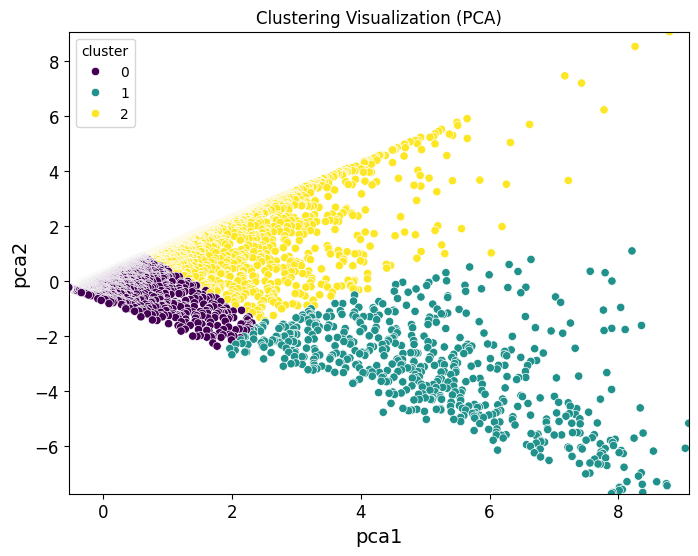

In [25]:
# df_filtered
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA

df_filtered_inf = top_score.replace([np.inf, -np.inf], np.nan).dropna()
X = df_filtered_inf[['lt_iqr', 'confidence']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

from sklearn.cluster import KMeans

k=3
kmeans = KMeans(n_clusters=k, random_state=0)
df_filtered_inf['cluster'] = kmeans.fit_predict(X_scaled)

# Reduce to 2D 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_filtered_inf['pca1'], df_filtered_inf['pca2'] = X_pca[:, 0], X_pca[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_filtered_inf, x='pca1', y='pca2', hue='cluster', palette='viridis')
plt.title('Clustering Visualization (PCA)')
plt.show()

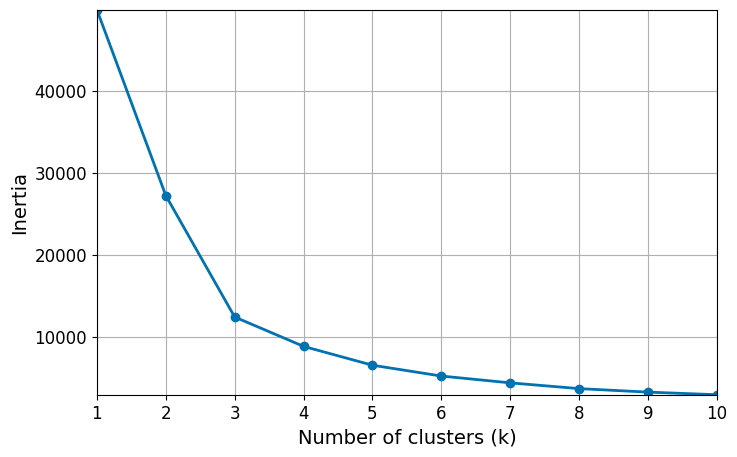

In [35]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertias = []
k_range = range(1, 11)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [37]:
df_filtered_inf.groupby('cluster')[['lt_iqr', 'loss', 'confidence_margin']].mean()

,lt_iqr,loss,confidence_margin
cluster,,,
0,0.121572,0.003961,18.348756
1,1.595733,0.104455,11.756542
2,1.030691,0.844148,1.475730


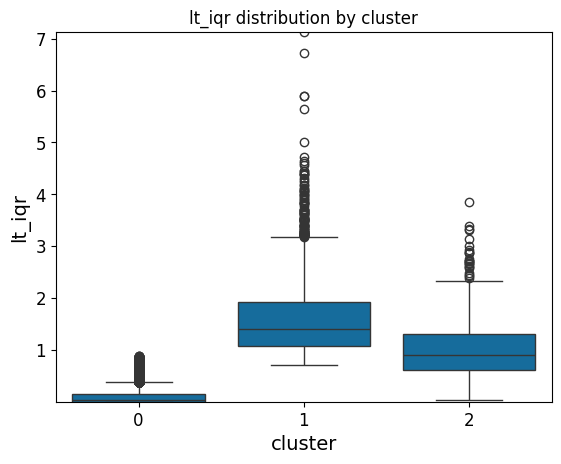

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_filtered_inf, x='cluster', y='lt_iqr')
plt.title("lt_iqr distribution by cluster")
plt.show()

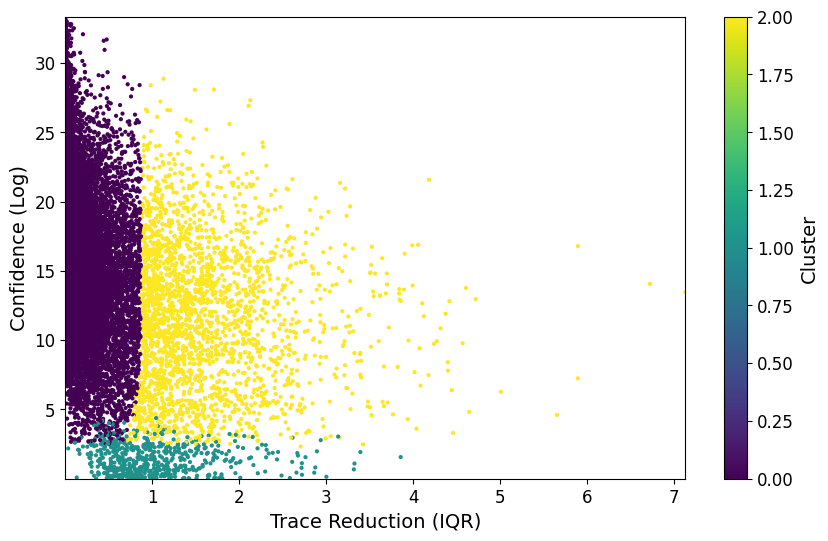

In [26]:
plt.figure(figsize=(10, 6))
color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}
plt.scatter(df_filtered_inf['lt_iqr'], df_filtered_inf['confidence_margin'], c=df_filtered_inf['cluster'], cmap='viridis', s=4)  # s=4 for marker size
plt.xlabel('Trace Reduction (IQR)')
plt.ylabel('Confidence (Log)')
plt.colorbar(label='Cluster')
plt.show()

In [41]:
safe = df_filtered_inf[df_filtered_inf['cluster'].isin([0])]['og_idx']
safe.to_csv("trained_models/layer_target_indices/cluster_test/layer_0_safe.csv", index=False)

In [40]:
df_filtered_inf['cluster'].value_counts()

cluster
0    21955
1     2434
2      570
Name: count, dtype: int64

In [35]:
idx = int(len(df_filtered_inf) * 0.0975)
df_filtered_inf[:idx]['cluster'].value_counts()

cluster
3    1983
2     269
1     125
0      58
Name: count, dtype: int64

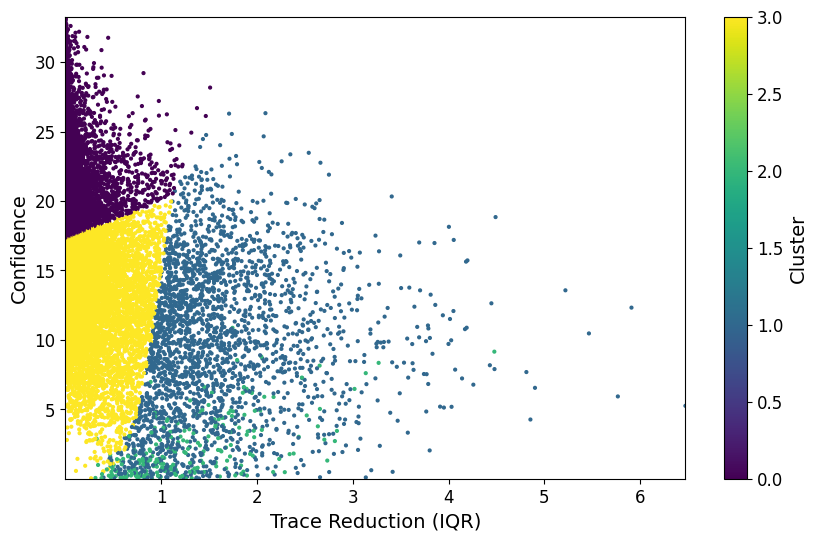

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered_inf['lt_iqr'], df_filtered_inf['confidence'], c=df_filtered_inf['cluster'], cmap='viridis', s=4)  # s=4 for marker size
plt.xlabel('Trace Reduction (IQR)')
plt.ylabel('Confidence')
plt.colorbar(label='Cluster')
plt.show()

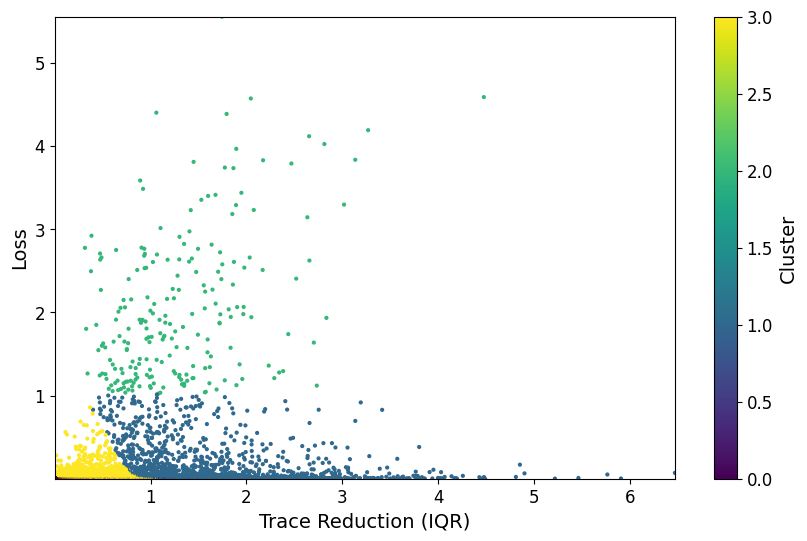

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered_inf['lt_iqr'], df_filtered_inf['loss'], c=df_filtered_inf['cluster'], cmap='viridis', s=4)  # s=4 for marker size
plt.xlabel('Trace Reduction (IQR)')
plt.ylabel('Loss')
plt.colorbar(label='Cluster')
plt.show()

## IGNORE

In [ ]:
import torchvision.transforms as transforms
top_k = 0.005
idx = int(len(top_score) * top_k)
top_k_score = top_score.iloc[-idx:]["og_idx"]
transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                   
                ])
attackset = get_trainset("CIFAR10", transform)
random_selection = np.random.choice(top_k_score.values, 15, replace=False)

fig, ax = plt.subplots(figsize=(10, 6))
for i, idx in enumerate(random_selection):
    img, label, _= attackset[idx]
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.axis("off")
    plt.savefig(f"figures/selected_images_{i}.png", bbox_inches='tight', dpi=300)



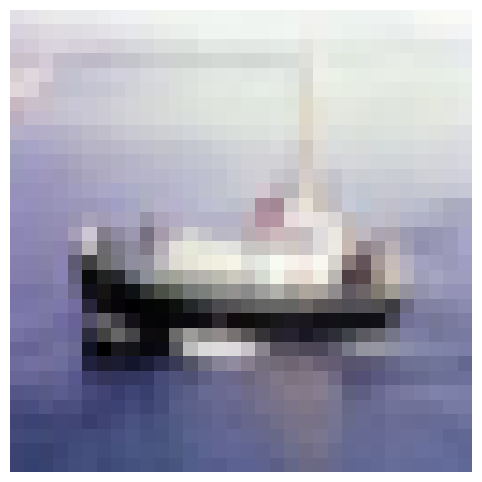

In [8]:

import torchvision.transforms as transforms
top_k = 0.005
idx = int(len(top_score) * top_k)
top_k_score = top_score.iloc[-idx:]["og_idx"]
transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                   
                ])
attackset = get_trainset("CIFAR10", transform)
random_selection = np.random.choice(top_k_score.values, 15, replace=False)

fig, ax = plt.subplots(figsize=(10, 6))
for i, idx in enumerate(random_selection):
    img, label, _= attackset[idx]
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.axis("off")
    plt.savefig(f"figures/safe_{i}.png", bbox_inches='tight', dpi=300)



KeyboardInterrupt: 

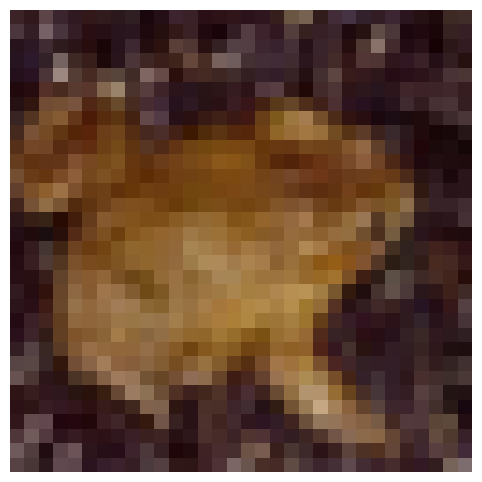

In [106]:
import torchvision.transforms as transforms
top_k = 0.005
idx = int(len(top_score) * top_k)
top_k_score = top_score.iloc[:idx]["og_idx"]
transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                   
                ])
attackset = get_trainset("CIFAR10", transform)
random_selection = np.random.choice(top_k_score.values, 15, replace=False)

fig, ax = plt.subplots(figsize=(10, 6))
for i, idx in enumerate(random_selection):
    img, label, _= attackset[idx]
    ax.imshow(img.permute(1, 2, 0).numpy())
    ax.axis("off")
    plt.savefig(f"figures/selected_images_{i}.png", bbox_inches='tight', dpi=300)



Most frequent labels in top_k:


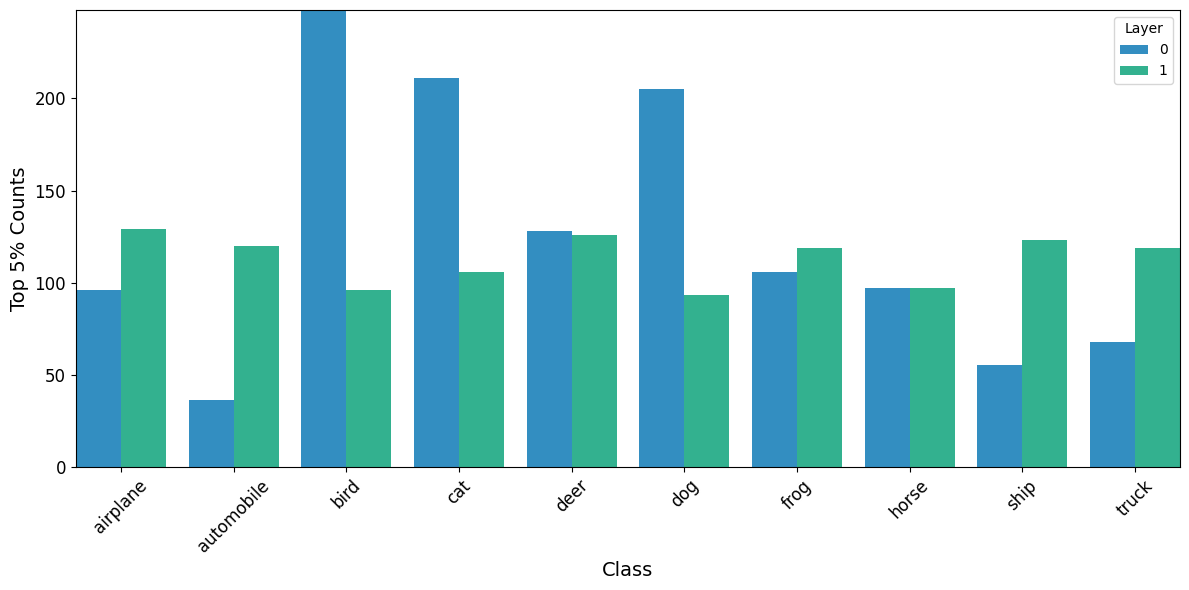

In [117]:
top_k = 0.05
num_classes = 10
exp_counts = {}
exp_labels = []
exp_ids = ["wrn28-2_CIFAR10", "wrn28-2_CIFAR10_l1"]

print("Most frequent labels in top_k:")

top_k = 0.05
cifar_labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

for layer, exp_id in enumerate(exp_ids):
    df = get_lira_scores(exp_id, n_shadows=32)
    df["lt_iqr"] = get_trace_reduction(exp_id, reduction="iqr")
    members = df[df['target_trained_on'] == True]
    top_score = members.sort_values(by='lt_iqr', ascending=False)
    idx = int(len(top_score) * top_k)
    top_k_score = top_score.iloc[:idx]["og_idx"]

    counts = {i: 0 for i in range(num_classes)}  
    for idx in top_k_score.values:
        img, label, _ = attackset[idx]
        counts[label] += 1

    exp_counts[exp_id] = [counts[i] for i in range(num_classes)]  
    exp_labels.append(exp_id)

# Plot
x = np.arange(num_classes)  
width = 0.8 / len(exp_ids)  # bar width adjusted for group size

plt.figure(figsize=(12, 6))
for i, exp_id in enumerate(exp_ids):
    plt.bar(x + i * width, exp_counts[exp_id], width, label=i, alpha=0.8)

plt.xlabel("Class")
plt.ylabel(f"Top {int(top_k*100)}% Counts")
plt.xticks(x + width * (len(exp_ids)-1)/2, cifar_labels, rotation=45)
plt.legend(title="Layer")
plt.tight_layout()
plt.savefig("figures/top_k_class_distribution.png", bbox_inches='tight', dpi=300)

Most frequent labels in bottom scores:


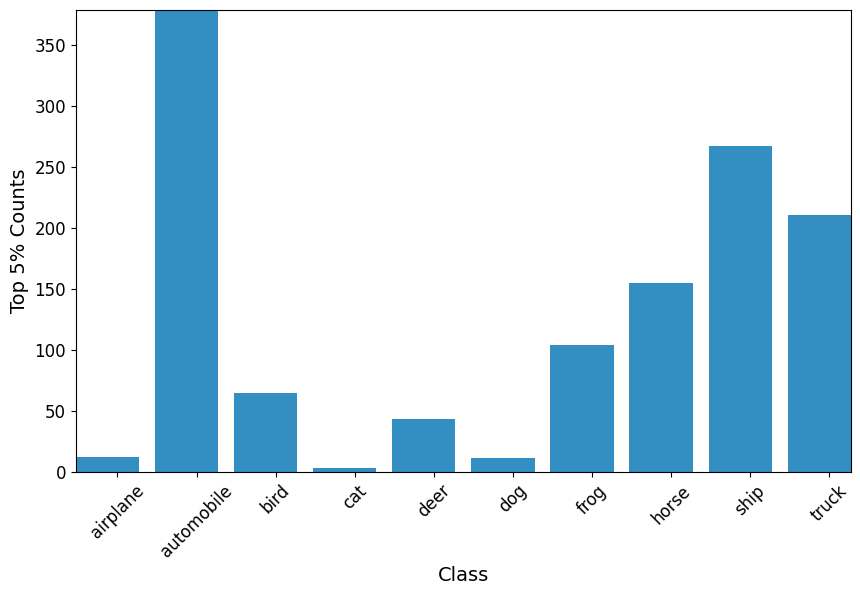

In [118]:
# get label counts in top_k
import matplotlib.pyplot as plt
import seaborn as sns

exp_id = "wrn28-2_CIFAR10"

df = get_lira_scores(exp_id, n_shadows=32)
df["lt_iqr"] = get_trace_reduction(exp_id, reduction="iqr")
members = df[df['target_trained_on'] == True]
top_score = members.sort_values(by='lt_iqr', ascending=False)

idx = int(len(top_score) * (1-top_k))
bottom_scores = top_score.iloc[idx:]["og_idx"]
# get label counts in bottom_k
counts_bottom = {}
for idx in bottom_scores.values:
    img, label, _ = attackset[idx]
    if label in counts_bottom:
        counts_bottom[label] += 1
    else:
        counts_bottom[label] = 1
print("Most frequent labels in bottom scores:")
plt.figure(figsize=(10, 6))
plt.bar(counts_bottom.keys(), counts_bottom.values(), alpha=0.8)
width = 0.5 / len(exp_ids)  # bar width adjusted for group size
plt.xticks(x + width * (len(exp_ids)-1)/2, cifar_labels, rotation=45)
plt.xlabel("Class")
plt.ylabel(f"Top {int(top_k*100)}% Counts")
plt.savefig("figures/bottom_k_class_distribution.png", bbox_inches='tight', dpi=300)


In [85]:
from collections import Counter

subset_targets = [true_attackset.dataset.targets[i] for i in true_attackset.indices]
label_counts = Counter(subset_targets)

for i in range(10):
    print(f"Label {i}: {label_counts[i]}")


Label 0: 2500
Label 1: 2500
Label 2: 2500
Label 3: 2500
Label 4: 2500
Label 5: 2500
Label 6: 2500
Label 7: 2500
Label 8: 2500
Label 9: 2500


In [8]:
import sklearn.metrics as metrics
def tpr_at_fpr(df, fpr=0.001, cols=["lira_score", "attackr_score", "rmia_score"]):
    labels = df["target_trained_on"]
    results = []
    for col in cols:
        scores = df[col]
        
        fpr_values, tpr_values, thresholds = metrics.roc_curve(labels, scores)
        idx = (np.abs(fpr_values - fpr)).argmin()
        tpr_at_fpr = tpr_values[idx]
        precision = metrics.precision_score(labels, scores > thresholds[idx])
        recall = metrics.recall_score(labels, scores > thresholds[idx])
        auc = metrics.roc_auc_score(labels, scores)
        
        results.append({
            'attack': col,
            f'tpr_at_fpr_{fpr}': tpr_at_fpr,
            'auc': auc,
            'precision': precision,
            'recall': recall
        })

    result_df = pd.DataFrame(results)
    return result_df

def calculate_roc(df: pd.DataFrame, cols=["lira_score", "attackr_score", "rmia_score"]):
    """
    Calculates FPR and TPR for each column in cols and adds them as new columns to the DataFrame.
    Returns a dictionary with attack names as keys and (fpr, tpr) tuples as values.
    """
    roc_data = {}
    for target_col in cols:
        fpr, tpr, _ = metrics.roc_curve(df['target_trained_on'], df[target_col])
        roc_data[target_col] = (fpr, tpr)
    return roc_data


def plot_roc(roc_data, save_path=None):
    """
    Plots ROC curves from roc_data (dict of {label: (fpr, tpr)}).
    Optionally, extra_curves (list of (fpr, tpr)) and extra_labels (list of str)
    can be provided.
    """
    plt.figure(figsize=(8, 6))
    for label, (fpr, tpr) in roc_data.items():
        if label == "rmia_score":
            label = "RMIA"
        elif label == "attackr_score":
            label = "AttackR"
        elif label == "lira_score":
            label = "LiRA"
        plt.plot(fpr, tpr, label=label)
    plt.plot(
        [0, 1], [0, 1],
        linestyle='--',
        color='gray',
        label='Random Guessing'
    )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.xscale("log")
    plt.yscale("log")
    plt.ylim(bottom=0.001)
    plt.xlim(left=0.001)
    plt.grid(True)
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.show()    

In [9]:
tpr_df = tpr_at_fpr(df, fpr=0.001, cols=["lira_score"])
tpr_df

,attack,tpr_at_fpr_0.001,auc,precision,recall
0,lira_score,0.0468,0.695456,0.979899,0.0468


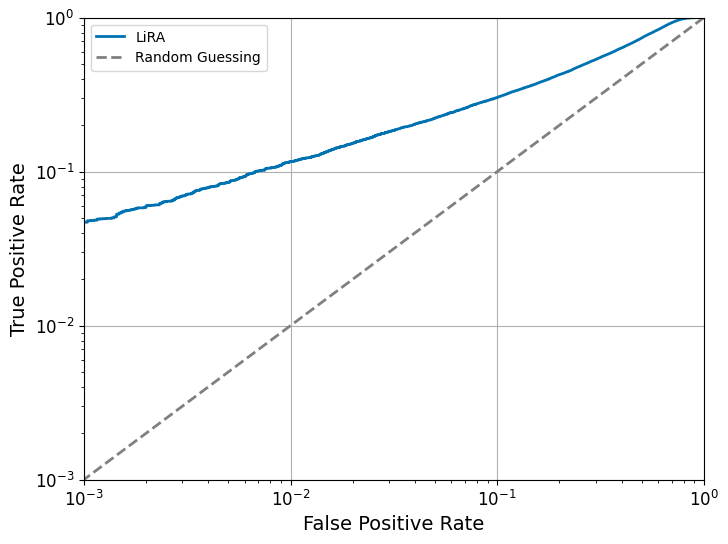

In [10]:
plot_roc(calculate_roc(df, cols=["lira_score"]),
         save_path="figures/roc_lira.png")

## CLustering

In [ ]:
save_path = f"{STORAGE_DIR}/layer_target_indices/{exp_id}"
os.makedirs(save_path, exist_ok=True)
top_k = 0.05
idx = int(len(top_score) * top_k)
layer = 1
top_score[:idx]['og_idx'].to_csv(
    f"{save_path}/layer_{layer}_vulnerable.csv",
    index=False
)

safe = top_score[idx:]["og_idx"]
safe.to_csv(
    f"{save_path}/layer_{layer}_safe.csv",
    index=False
)

safe.to_pickle(f"{save_path}/layer_{layer}_safe.pkl")

In [22]:
features = {'my_layer': []}  # initialize as list BEFORE any forward pass

def hook_fn(module, input, output):
    features['my_layer'].append(output.detach().cpu())

hook = model.relu.register_forward_hook(hook_fn)

model.eval()
with torch.no_grad():
    for batch in data_loader[0]:
        input_tensor = batch[0].to(config['device'])
        _ = model(input_tensor)

hook.remove()

# concatenate once after all batches processed
features['my_layer'] = torch.cat(features['my_layer'], dim=0)

filter = saves["trained_on_indices"]
filtered_features = features["my_layer"][filter]
print(filtered_features.shape)


torch.Size([25000, 128, 8, 8])


In [70]:
from sklearn.cluster import KMeans
import numpy as np

k = 9
flattened = filtered_features.view(filtered_features.size(0), -1)  # flatten per sample
embeddings_pooled = filtered_features.mean(dim=(2, 3))
# Cluster your data (use embeddings/features, not raw data)
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(flattened)

# For each cluster, find points closest to centroid
core_indices = []
for cluster_id in range(k):
    cluster_mask = clusters == cluster_id
    cluster_points = flattened[cluster_mask]
    cluster_indices = np.where(cluster_mask)[0]
    
    # Distance to centroid
    centroid = kmeans.cluster_centers_[cluster_id]
    distances = np.linalg.norm(cluster_points - centroid, axis=1)
    
    # Keep top N% closest to centroid as core
    n_core = int(0.3 * len(cluster_points))  # 30% of each cluster
    core_in_cluster = np.argsort(distances)[:n_core]
    core_indices.extend(cluster_indices[core_in_cluster])

/tmp/ipykernel_2399598/3455059817.py:20: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  distances = np.linalg.norm(cluster_points - centroid, axis=1)


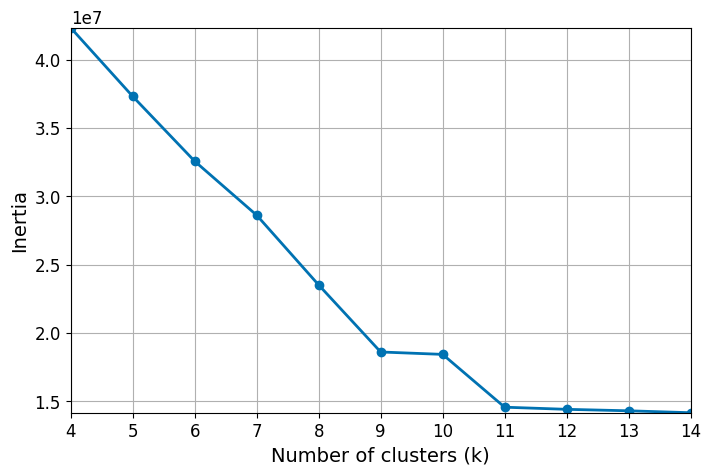

In [68]:
inertias = []
k_range = range(4, 15)  

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(flattened)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [71]:
df_filtered_inf['core'] = df_filtered_inf.index.isin(core_indices)

In [26]:
df_filtered_inf.to_csv(f"original_target_clustered.csv", index=False)

In [72]:
df_filtered_inf[:idx].groupby('core')['cluster'].value_counts()

core   cluster
False  1          993
       2           62
       0            2
True   1          177
       2           16
Name: count, dtype: int64

In [58]:
vuln = df_filtered_inf[~df_filtered_inf['core']][:idx]['og_idx']
safe = [i for i in saves['trained_on_indices'] if i not in vuln.values]
full_safe = [i for i in range(len(df)) if i not in vuln.values]

In [64]:
pd.Series(safe, name='og_idx').to_csv(f"safe_indices_clustering_l0.csv", index=False)
pd.Series(full_safe, name='og_idx').to_csv(f"full_safe_indices_clustering_l0.csv", index=False)

In [ ]:

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# filter features if in saves[trained_on]
filter = saves["trained_on_indices"]
filtered_features = features["my_layer"][filter]
data_len = filtered_features.shape[0]
vulnerable_indices = top_score[:idx]['og_idx'].values
labels = [1 if x in vulnerable_indices else 0 for x in range(data_len)]

flattened = filtered_features.view(filtered_features.size(0), -1)  # flatten per sample

tsne = TSNE(n_components=2, random_state=42, verbose=1, n_iter=1000, perplexity=30)

tsne_results = tsne.fit_transform(flattened.cpu().numpy())

In [ ]:
# plt.figure(figsize=(10, 8))
# plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=labels, alpha=0.25, cmap='coolwarm')
# plt.title("t-SNE of Penultimate Layer (WRN)")
# plt.show()

NameError: name 'tsne_results' is not defined

<Figure size 1000x800 with 0 Axes>

In [ ]:
for name, module in model.named_modules():
    print(name)


conv1
block1
block1.layer
block1.layer.0
block1.layer.0.bn1
block1.layer.0.relu1
block1.layer.0.conv1
block1.layer.0.bn2
block1.layer.0.relu2
block1.layer.0.conv2
block1.layer.0.convShortcut
block1.layer.1
block1.layer.1.bn1
block1.layer.1.relu1
block1.layer.1.conv1
block1.layer.1.bn2
block1.layer.1.relu2
block1.layer.1.conv2
block1.layer.2
block1.layer.2.bn1
block1.layer.2.relu1
block1.layer.2.conv1
block1.layer.2.bn2
block1.layer.2.relu2
block1.layer.2.conv2
block1.layer.3
block1.layer.3.bn1
block1.layer.3.relu1
block1.layer.3.conv1
block1.layer.3.bn2
block1.layer.3.relu2
block1.layer.3.conv2
block2
block2.layer
block2.layer.0
block2.layer.0.bn1
block2.layer.0.relu1
block2.layer.0.conv1
block2.layer.0.bn2
block2.layer.0.relu2
block2.layer.0.conv2
block2.layer.0.convShortcut
block2.layer.1
block2.layer.1.bn1
block2.layer.1.relu1
block2.layer.1.conv1
block2.layer.1.bn2
block2.layer.1.relu2
block2.layer.1.conv2
block2.layer.2
block2.layer.2.bn1
block2.layer.2.relu1
block2.layer.2.conv1

In [74]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
all_confidences = []
all_margins = []
with torch.no_grad():
    for inputs, targets, _indices in data_loader[0]:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs).squeeze(-1).squeeze(-1)  # logits

        # Convert logits to probabilities
        probs = torch.softmax(outputs, dim=1)

        # Get top-2 probabilities for margin calculation
        top2_probs, top2_indices = torch.topk(probs, k=2, dim=1)  # shape: (batch_size, 2)

        # Top-1 predicted class (already sorted)
        predicted = top2_indices[:, 0]
        top1_conf = top2_probs[:, 0]
        top2_conf = top2_probs[:, 1]

        # Confidence margin (top1 - top2)
        conf_margin = top1_conf - top2_conf

        # # For accuracy (optional)
        # correct_idx = predicted.eq(targets.data).cpu()
        # correct += correct_idx.sum()
        # total += targets.size(0)

        # Save confidences if needed
        all_confidences.extend(top1_conf.tolist())
        all_margins.extend(conf_margin.tolist())


In [ ]:
df['confidence'] = all_confidences
df['margin'] = all_margins

In [89]:
df_sorted = df.sort_values(by='lt_iqr', ascending=False)
top_df_sorted = df_sorted[df_sorted['target_trained_on'] == True][:idx]
remaining_df = df_sorted[df_sorted['target_trained_on'] == True][idx:]

In [92]:
top_df_sorted['margin'].describe()

count    1250.000000
mean        0.893162
std         0.206538
min         0.025461
25%         0.908612
50%         0.987469
75%         0.998427
max         0.999998
Name: margin, dtype: float64

In [93]:
remaining_df['margin'].describe()

count    23750.000000
mean         0.981599
std          0.095994
min          0.002253
25%          0.998380
50%          0.999783
75%          0.999960
max          1.000000
Name: margin, dtype: float64

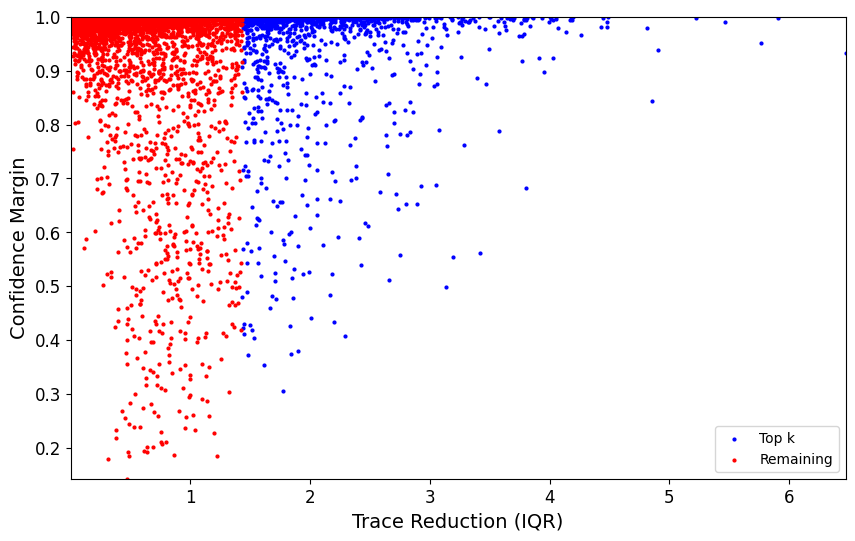

In [98]:
plt.figure(figsize=(10, 6))
plt.scatter(top_df_sorted['lt_iqr'], top_df_sorted['confidence'], s=4, c='blue', label='Top k')
plt.scatter(remaining_df['lt_iqr'], remaining_df['confidence'], s=4, c='red', label='Remaining')
plt.xlabel('Trace Reduction (IQR)')
plt.ylabel('Confidence Margin')
plt.legend()
# plt.ylim(0.95, 1.0)

In [ ]:
# cluster
import kmeans